# 8B1_tf_tf_enrichment

07/20/2020

getting tf-tf enriched pairs for each tissue for each geneset



In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time

# machine learning packages from sklearn
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn import preprocessing, metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from IPython.display import Image
from scipy import stats

# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
save_dir = '../data/processed/fig4_modelling/tf_tf_pairs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
THRES=5

In [5]:
tf_annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
tf_annon_df['id_trim'] = tf_annon_df['id'] + '.pwm.trim'
tf_name_to_id_dict = pd.Series(tf_annon_df.id_trim.values, index=tf_annon_df.tf.values).to_dict()
tf_id_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id_trim.values).to_dict()

In [6]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal','GDSD0','GDSD3','GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

In [7]:
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
rna_df_norm = rna_df[normal_tissues]

# 0. CRM data wrangling and global var setup

In [43]:
%%time
# import
data_all = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/processed/tissue_crms/all_count_comb_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(normal_tissues)]
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]

# expression labels
exp_label = list(np.log10(data_all.exp.values+1e-2))
labels_all  = np.array(np.array(exp_label)>THRES)

tissues_label  = data_all.tissue.values#np.array((data_all.exp>THRES).values)
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values

genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)



CPU times: user 1min 29s, sys: 24.1 s, total: 1min 53s
Wall time: 1min 38s


In [44]:
print('files_loaded', data_all.shape)


files_loaded (156071, 1063)


In [45]:
## only tfs

data_all.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape




(156071, 1057)

In [46]:
data_all[:5]

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,ATF7_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A4GALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AANAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#tfs_feat_dict: dict
# key: tf
# value: list of crm features
tfs_feat_dict = defaultdict(list)
for feat in data_all.columns:
    tfs_feat_dict[feat.split('_')[0]].append(feat)

# 1. Functions 

In [48]:
def find_tf_pairs(single_results, tfs_feat_dict=tfs_feat_dict, data_all=data_all):
    tfs_unique = single_results[single_results.pval_bonf<0.05].tf_key.unique()
    print('num single unique TFs', len(tfs_unique))
    TF_pair_dict = defaultdict(list)
    for tf1 in tfs_unique:
        for tf2 in tfs_unique:
            if (tf1<tf2):
                if (tf1 in tfs_feat_dict) and (tf2 in tfs_feat_dict):
                    possible_feats = [tf1+'_pro',tf1+'_loop',tf2+'_pro',tf2+'_loop']
                    for feat in possible_feats:
                        if feat in data_all.columns:
                            TF_pair_dict[tf1+'::'+tf2].append(feat)
    print('num pairs of TFs', len(TF_pair_dict))
    return TF_pair_dict

In [49]:
# TF_feat_dict: dict, key = tf_key (string of tfs sep by ::), val; list of features/columns of data_all
# backgound: relative means the background in the data_all_sel, if 'all' then background is data_all
# def tf_enrichment(geneset, tissues=normal_tissues, data_all=data_all,tissues_label=tissues_label, background='all'):
def tf_enrichment(geneset, TF_feat_dict, tissues=normal_tissues, 
                  data_all=data_all,tissues_label=tissues_label, 
                  background='relative',verbose=True, save_path=None):
    # get subset
    data_all_sel = data_all[data_all.index.isin(geneset)]
    tissues_label_sel = tissues_label[data_all.index.isin(geneset)]
    if verbose:
        print('num genes in geneset',len(geneset))
        print('subsetting data,', data_all_sel.shape, tissues_label_sel.shape)
    
    # set background and initial variables
    results_df = pd.DataFrame(columns = ['tf_key', 'tissue', 'jaccard', 'intersect_over_min','intersection','union', 'num_in_gene', 'num_in_feat', 'observed', 'expected', 'oddsratio', 'pval' ])
    counter = 0
    if background=='all':
        count_all = data_all.sum().sum()
    else:
        count_all = data_all_sel.sum().sum() ## background
    
    # iterate through tissues
    if verbose:
        print('starting iteration')
        print('estimated count', len(TF_feat_dict)*len(tissues))
    for tissue in tissues:
        if verbose:
            print('*****iterating tissue, ', tissue)
        tissue_crm = data_all_sel[tissues_label_sel==tissue]
        tissue_crm = tissue_crm[tissue_crm.index.isin(geneset)]
        count_tissue_gene = tissue_crm.sum().sum() #mat_counts.sum(axis=1)[0], sum first row
        
        # iterate through tfs
        for tf_key, feat_list in sorted(TF_feat_dict.items(),key=lambda x: x[0]):
            if len(feat_list)>0:
                tissue_crm_selfeat = tissue_crm[feat_list]
                count_selfeat_tissue = tissue_crm_selfeat.sum().sum() # A
                count_selfeat = data_all_sel[feat_list].sum().sum() #mat_counts.sum(axis=0)[0], sum down first col
                count_selfeat_neg = count_selfeat - count_selfeat_tissue # B: not in selected genes but in selected feature
                count_neg_tissue = count_tissue_gene - count_selfeat_tissue #C: not in selected feature but in selected genes
                count_neg_neg = count_all - count_selfeat_tissue- count_selfeat_neg - count_neg_tissue #D
                mat_counts = np.array([[count_selfeat_tissue,count_neg_tissue],
                               [count_selfeat_neg, count_neg_neg]]).reshape((2,2))
                pseudo = 1
                mat_counts_pseudo = mat_counts+pseudo
                num_in_1 = mat_counts.sum(axis=1)[0] #count_tissue_gene
                num_in_2 = mat_counts.sum(axis=0)[0] #count_selfeat
                in_1_and_in_2 = count_selfeat_tissue # A
                in_1_or_in_2 = count_selfeat_tissue +count_selfeat_neg+count_neg_tissue # A+B+C
                in_1 = count_selfeat_tissue+count_neg_tissue # A+C
                in_2 = count_selfeat_tissue+count_selfeat_neg#A+B
                observed_num = mat_counts[0][0] #count_KRTtf_KRTgene
                expected_num = num_in_1*num_in_2/sum(sum(mat_counts))
                oddsratio_pseudo, pvalue_pseudo = stats.fisher_exact(mat_counts_pseudo,alternative='greater')
                jaccard = in_1_and_in_2/in_1_or_in_2
                intersect_over_min = in_1_and_in_2/min(in_1,in_2)

                results_df.at[counter] = {'tf_key':tf_key, 'tissue':tissue,
                                            'jaccard':jaccard,'intersect_over_min':intersect_over_min,
                                        'intersection':in_1_and_in_2, 
                                       'union':in_1_or_in_2, 
                                       'num_in_gene':num_in_1,'num_in_feat':num_in_2,
                                       'observed':observed_num, 'expected':expected_num, 
                                       'oddsratio':oddsratio_pseudo, 'pval':pvalue_pseudo}
                counter+=1
                if verbose:
                    if (counter %1000)==0:
                        print(tf_key, tissue, counter)

    
    results_df['pval_bonf'] = results_df.pval.apply(lambda x: min(1, x* results_df.shape[0]))#sum(sum(mat_counts))))#
    results_df['log_pval_bonf'] = results_df.pval_bonf.apply(lambda x: min(100,-np.log10(x+1e-100)))
    
    if save_path is not None:
        results_df.to_csv(save_path)
        print('saved file', save_path)
    return results_df

# 2. get gene sets

create dictionary {tissue: gene_list} for each category

2A. unique gene lists for each cell type

In [50]:
glob.glob('../../rnaseq/unique_gene_lists/*genes.txt')

['../../rnaseq/unique_gene_lists/Colon_genes.txt',
 '../../rnaseq/unique_gene_lists/GDSD0_genes.txt',
 '../../rnaseq/unique_gene_lists/Airway_genes.txt',
 '../../rnaseq/unique_gene_lists/GDSD6_genes.txt',
 '../../rnaseq/unique_gene_lists/Pancreas_genes.txt',
 '../../rnaseq/unique_gene_lists/Uterine_genes.txt',
 '../../rnaseq/unique_gene_lists/Ovarian_genes.txt',
 '../../rnaseq/unique_gene_lists/Astrocytes_genes.txt',
 '../../rnaseq/unique_gene_lists/Bladder_genes.txt',
 '../../rnaseq/unique_gene_lists/Melanocytes_genes.txt',
 '../../rnaseq/unique_gene_lists/HMEC_genes.txt',
 '../../rnaseq/unique_gene_lists/Prostate_genes.txt',
 '../../rnaseq/unique_gene_lists/GM12878_genes.txt',
 '../../rnaseq/unique_gene_lists/Renal_genes.txt',
 '../../rnaseq/unique_gene_lists/GDSD3_genes.txt',
 '../../rnaseq/unique_gene_lists/Esophageal_genes.txt',
 '../../rnaseq/unique_gene_lists/Thyroid_genes.txt']

In [51]:
unique_genesets = {}
for rna_file in glob.glob('../../rnaseq/unique_gene_lists/*genes.txt'):
    tissue = os.path.basename(rna_file).split('_')[0]
    geneset = sorted(pd.read_csv(rna_file,header=None).loc[:,0].dropna().unique())
    print(tissue, len(geneset))
    unique_genesets[tissue] = geneset
    

Colon 14
GDSD0 14
Airway 41
GDSD6 240
Pancreas 17
Uterine 37
Ovarian 27
Astrocytes 465
Bladder 37
Melanocytes 226
HMEC 49
Prostate 312
GM12878 447
Renal 27
GDSD3 61
Esophageal 19
Thyroid 44


2B. expressed gene lists for each cell type

In [52]:
THRES=5

In [53]:
expr_genesets = {}
for tissue in rna_df_norm.columns:
    geneset = list(rna_df_norm[tissue][rna_df_norm[tissue]>THRES].index)
    print(tissue, len(geneset))
    expr_genesets[tissue] = geneset

Airway 6815
Astrocytes 7303
Bladder 6642
Colon 6826
Esophageal 6651
GDSD0 7031
GDSD3 6970
GDSD6 6442
GM12878 6166
HMEC 6972
Melanocytes 7359
Ovarian 6578
Pancreas 7055
Prostate 6516
Renal 6901
Thyroid 7003
Uterine 6569


2C. group genesets

In [54]:
print(glob.glob('../data/interim/rna/*_genes.csv'))
group_tissue_mapping = {
    'blue':['Astrocytes','Melanocytes'],
    'grey':['GM12878'],
    'green':['Colon','Esophageal','Ovarian','Pancreas','Renal','Thyroid'],
    'purple':['Airway','Bladder', 'GDSD0','GDSD6', 'HMEC', 'Prostate', 'Uterine'] 
}

['../data/interim/rna/purple_genes.csv', '../data/interim/rna/green_genes.csv', '../data/interim/rna/common_genes.csv', '../data/interim/rna/all_genes.csv', '../data/interim/rna/grey_genes.csv', '../data/interim/rna/blue_genes.csv']


In [55]:
group_genesets = {}
for group, tissues in group_tissue_mapping.items():
    geneset = sorted(pd.read_csv('../data/interim/rna/'+group+'_genes.csv',header=None).loc[:,0].dropna().unique())
    for tissue in tissues:
        group_genesets[tissue] = geneset
        print(tissue, len(geneset))
        

Astrocytes 954
Melanocytes 954
GM12878 626
Colon 759
Esophageal 759
Ovarian 759
Pancreas 759
Renal 759
Thyroid 759
Airway 796
Bladder 796
GDSD0 796
GDSD6 796
HMEC 796
Prostate 796
Uterine 796


# 3. running pairwise enrichments

In [56]:
def run_pair_enrichment(tissue, save_prefix, geneset_dict):
    if tissue not in geneset_dict:
        print(tissue, 'not found in geneset_dict')
        return
    results_df = tf_enrichment(geneset=geneset_dict[tissue], TF_feat_dict=tfs_feat_dict, tissues=[tissue], 
                      data_all=data_all,tissues_label=tissues_label, 
                      background='relative',verbose=True, save_path=os.path.join(save_dir, save_prefix+tissue + '_single.csv'))
    # filter for cell type
    results_df_filt = results_df[(results_df.pval_bonf<0.05 )&( results_df.tissue==tissue)]
    # downsample # of tf tf pairs to consider
    tfs_feat_dict_pairs = find_tf_pairs(single_results=results_df_filt, tfs_feat_dict=tfs_feat_dict, data_all=data_all)

    results_df_pairs = tf_enrichment(geneset=geneset_dict[tissue], TF_feat_dict=tfs_feat_dict_pairs, tissues=[tissue], 
                      data_all=data_all,tissues_label=tissues_label, 
                      background='relative',verbose=True, save_path=os.path.join(save_dir,  save_prefix+tissue + '_pair.csv'))

    results_df_pairs_filt = results_df_pairs[(results_df_pairs.oddsratio>1) & (results_df_pairs.pval_bonf<0.05)]
    results_df_pairs_filt.to_csv(os.path.join(save_dir,  save_prefix+tissue + '_pair_filt.csv'))
    # results_df_KRT_pairs_filt = results_df_KRT_pairs_filt[results_df_KRT_pairs_filt.num_in_2>=(results_df_KRT_pairs_filt.observed+10)]
    print('num sig tf-tf pair in ', tissue, results_df_pairs_filt.shape)

In [57]:
results_df = pd.read_csv(os.path.join(save_dir, 'expr_Melanocytes_single.csv'),index_col=0)
results_df_filt = results_df[(results_df.pval_bonf<0.05 )&( results_df.tissue=='Melanocytes')]

In [13]:
results_df_filt

,tf_key,tissue,jaccard,intersect_over_min,intersection,union,num_in_gene,num_in_feat,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
4233,ALX1,Melanocytes,0.000204,1.000000,32.0,156637.0,156637.0,32.0,32.0,0.683956,1511.257385,2.553332e-54,1.871213e-47,46.727877
4239,ARNT2,Melanocytes,0.006935,0.393548,1098.0,158329.0,156637.0,2790.0,1098.0,59.632448,29.924649,0.000000e+00,0.000000e+00,100.000000
4253,BATF3,Melanocytes,0.000488,0.057721,77.0,157894.0,156637.0,1334.0,77.0,28.512432,2.839796,7.425422e-15,5.441731e-08,7.264263
4269,CPEB1,Melanocytes,0.001954,1.000000,306.0,156637.0,156637.0,306.0,306.0,6.540333,14083.914656,0.000000e+00,0.000000e+00,100.000000
4272,CREB3L1,Melanocytes,0.000662,0.053435,105.0,158497.0,156637.0,1965.0,105.0,41.999197,2.608998,3.454894e-17,2.531924e-10,9.596549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,ZNF436,Melanocytes,0.001021,0.072386,162.0,158713.0,156637.0,2238.0,162.0,47.834200,3.595924,3.698606e-40,2.710528e-33,32.566946
4735,ZNF449,Melanocytes,0.002488,0.416400,391.0,157185.0,156637.0,939.0,391.0,20.069845,32.771909,0.000000e+00,0.000000e+00,100.000000
4742,ZNF549,Melanocytes,0.000236,0.126280,37.0,156893.0,156637.0,293.0,37.0,6.262476,6.771320,1.748843e-18,1.281642e-11,10.892233
4746,ZNF589,Melanocytes,0.014911,0.063435,2995.0,200856.0,156637.0,47214.0,2995.0,1009.134910,3.143093,0.000000e+00,0.000000e+00,100.000000


In [26]:
%%time
# get expressed tissue geneset enrichments
for tissue in ['GDSD0']:
    print('============ Running expressed', tissue)
    run_pair_enrichment(tissue, save_prefix='expr_', geneset_dict = expr_genesets)

============ Running expressed GDSD0
num genes in geneset 7031
subsetting data, (64582, 1057) (64582,)
starting iteration
estimated count 529
*****iterating tissue,  GDSD0


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_single.csv
num single unique TFs 136
num pairs of TFs 9180
num genes in geneset 7031
subsetting data, (64582, 1057) (64582,)
starting iteration
estimated count 9180
*****iterating tissue,  GDSD0
BCL11A::PITX2 GDSD0 1000
DLX3::SMAD4 GDSD0 2000
FOSL2::KLF9 GDSD0 3000
HBP1::TEAD3 GDSD0 4000
HOXC10::HOXD8 GDSD0 5000
JDP2::ZFP28 GDSD0 6000
MYBL2::SREBF1 GDSD0 7000
POU2F1::ZNF554 GDSD0 8000
ZFP42::ZNF41 GDSD0 9000
saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair.csv
num sig tf-tf pair in  GDSD0 (9180, 14)
CPU times: user 2min 7s, sys: 19.8 s, total: 2min 27s
Wall time: 2min 27s


In [58]:
%%time
# get expressed tissue geneset enrichments
for tissue in ['GDSD3']:
    print('============ Running expressed', tissue)
    run_pair_enrichment(tissue, save_prefix='expr_', geneset_dict = expr_genesets)

============ Running expressed GDSD3
num genes in geneset 6970
subsetting data, (68474, 1057) (68474,)
starting iteration
estimated count 529
*****iterating tissue,  GDSD3


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_single.csv
num single unique TFs 78
num pairs of TFs 3003
num genes in geneset 6970
subsetting data, (68474, 1057) (68474,)
starting iteration
estimated count 3003
*****iterating tissue,  GDSD3
GLI1::HOXC13 GDSD3 1000
HOXD8::ZBTB6 GDSD3 2000
ZNF554::ZNF85 GDSD3 3000
saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair.csv
num sig tf-tf pair in  GDSD3 (3003, 14)
CPU times: user 40.8 s, sys: 7.72 s, total: 48.5 s
Wall time: 48.5 s


In [40]:
%%time
# get expressed tissue geneset enrichments
for tissue in ['Melanocytes']:
    print('============ Running expressed', tissue)
    run_pair_enrichment(tissue, save_prefix='expr_', geneset_dict = expr_genesets)

============ Running expressed Melanocytes
num genes in geneset 7359
subsetting data, (62298, 1057) (62298,)
starting iteration
estimated count 529
*****iterating tissue,  Melanocytes


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_single.csv
num single unique TFs 85
num pairs of TFs 3570
num genes in geneset 7359
subsetting data, (62298, 1057) (62298,)
starting iteration
estimated count 3570
*****iterating tissue,  Melanocytes
ETV2::ZNF18 Melanocytes 1000
HSF4::RFX3 Melanocytes 2000
PRRX1::ZNF41 Melanocytes 3000
saved file ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair.csv
num sig tf-tf pair in  Melanocytes (3570, 14)
CPU times: user 49.1 s, sys: 23.4 s, total: 1min 12s
Wall time: 1min 12s


In [41]:
# %%time
# # get unique tissue geneset enrichments
# for tissue in normal_tissues:
#     print('============ Running unique', tissue)
#     run_pair_enrichment(tissue, save_prefix='unique_', geneset_dict = unique_genesets)

In [42]:
# %%time
# # get expressed tissue geneset enrichments
# for tissue in normal_tissues:
#     print('============ Running expressed', tissue)
#     run_pair_enrichment(tissue, save_prefix='expr_', geneset_dict = expr_genesets)

In [43]:
# %%time
# # get group tissue geneset enrichments
# for tissue in normal_tissues:
#     print('============ Running group', tissue)
#     run_pair_enrichment(tissue, save_prefix='group_', geneset_dict = group_genesets)

# 4. Curating list of tf-tf pairs

# 5. filter curating list to find combinations that are close together

In [59]:
for filepath in sorted(glob.glob(os.path.join(save_dir, '*_filt.csv'))):
    df = pd.read_csv(filepath, index_col=0)
    print(os.path.basename(filepath), df.shape)

expr_Airway_pair_filt.csv (3403, 14)
expr_Astrocytes_pair_filt.csv (4560, 14)
expr_Bladder_pair_filt.csv (10878, 14)
expr_Colon_pair_filt.csv (2080, 14)
expr_Esophageal_pair_filt.csv (3321, 14)
expr_GDSD0_pair_filt.csv (9180, 14)
expr_GDSD3_pair_filt.csv (3003, 14)
expr_GDSD6_pair_filt.csv (10440, 14)
expr_GM12878_pair_filt.csv (6555, 14)
expr_HMEC_pair_filt.csv (4753, 14)
expr_Melanocytes_pair_filt.csv (3570, 14)
expr_Ovarian_pair_filt.csv (4560, 14)
expr_Pancreas_pair_filt.csv (3240, 14)
expr_Prostate_pair_filt.csv (7260, 14)
expr_Renal_pair_filt.csv (2278, 14)
expr_Thyroid_pair_filt.csv (2016, 14)
expr_Uterine_pair_filt.csv (15225, 14)
group_Airway_pair_filt.csv (276, 14)
group_Astrocytes_pair_filt.csv (528, 14)
group_Bladder_pair_filt.csv (2850, 14)
group_Colon_pair_filt.csv (171, 14)
group_Esophageal_pair_filt.csv (406, 14)
group_GDSD6_pair_filt.csv (2278, 14)
group_GM12878_pair_filt.csv (3655, 14)
group_HMEC_pair_filt.csv (435, 14)
group_Melanocytes_pair_filt.csv (496, 14)
group_

In [60]:
# get tissue specific tf-tf and global tf-tf pairs useful for expr
expr_all_tissue_df = pd.DataFrame()
for filepath in sorted(glob.glob(os.path.join(save_dir, 'expr*_filt.csv'))):
    df = pd.read_csv(filepath, index_col=0)
    print(os.path.basename(filepath), df.shape)
    expr_all_tissue_df = pd.concat([expr_all_tissue_df, df], axis=0,sort=False)


expr_Airway_pair_filt.csv (3403, 14)
expr_Astrocytes_pair_filt.csv (4560, 14)
expr_Bladder_pair_filt.csv (10878, 14)
expr_Colon_pair_filt.csv (2080, 14)
expr_Esophageal_pair_filt.csv (3321, 14)
expr_GDSD0_pair_filt.csv (9180, 14)
expr_GDSD3_pair_filt.csv (3003, 14)
expr_GDSD6_pair_filt.csv (10440, 14)
expr_GM12878_pair_filt.csv (6555, 14)
expr_HMEC_pair_filt.csv (4753, 14)
expr_Melanocytes_pair_filt.csv (3570, 14)
expr_Ovarian_pair_filt.csv (4560, 14)
expr_Pancreas_pair_filt.csv (3240, 14)
expr_Prostate_pair_filt.csv (7260, 14)
expr_Renal_pair_filt.csv (2278, 14)
expr_Thyroid_pair_filt.csv (2016, 14)
expr_Uterine_pair_filt.csv (15225, 14)


In [61]:
# unique
tf_tf_pair_counter = expr_all_tissue_df.tf_key.value_counts()
tf_tf_pair_counter[tf_tf_pair_counter==1].shape, tf_tf_pair_counter.shape

((28384,), (50775,))

In [62]:
# create filtered expression datasets (vocabs that are responsible for expression that are tissue specific
for filepath in sorted(glob.glob(os.path.join(save_dir, 'expr*_filt.csv'))):
    tissue = os.path.basename(filepath).split('_')[1]
    df = pd.read_csv(filepath, index_col=0)
    df_filt = df[df.tf_key.isin(tf_tf_pair_counter[tf_tf_pair_counter<=3].index)]
    print(tissue, df.shape[0], df_filt.shape[0])
    df_filt.to_csv(os.path.join(save_dir, 'expr_'+tissue+'_pair_filt_unique.csv'))

Airway 3403 1388
Astrocytes 4560 4231
Bladder 10878 7648
Colon 2080 954
Esophageal 3321 2107
GDSD0 9180 5171
GDSD3 3003 1336
GDSD6 10440 6886
GM12878 6555 5664
HMEC 4753 1909
Melanocytes 3570 3003
Ovarian 4560 4206
Pancreas 3240 1296
Prostate 7260 6086
Renal 2278 958
Thyroid 2016 869
Uterine 15225 12730


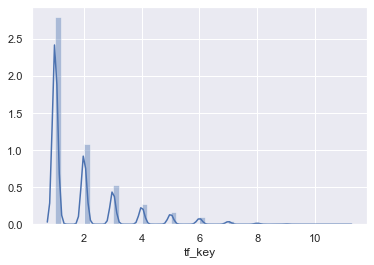

In [63]:
sns.distplot(tf_tf_pair_counter)

In [64]:
tf_tf_pair_counter[tf_tf_pair_counter>6]

KLF9::ZNF554     11
KLF9::PBX1       11
PBX1::RARG       10
PLAGL1::PRDM1    10
KLF9::PLAG1      10
                 ..
FOSL1::TBX3       7
SP2::ZBTB33       7
GLIS3::PLAG1      7
JDP2::PBX1        7
GLI3::TP53        7
Name: tf_key, Length: 653, dtype: int64

In [36]:
def check_tf_tf_loop_occur(tf_tf_pair, tissue, genesets_dict, data_all=data_all, tissues_label=tissues_label):  #suffixes='loop', 'pro_loop'
    tf_1, tf_2 = tf_tf_pair.split('::')
    
    # get features to look at together, list of lists
    feat_list_type = {
        'pro_pro':[tf_1 + '_pro', tf_2+'_pro'],
        'loop_loop':[tf_1 + '_loop', tf_2+'_loop'],
        'pro_loop':[tf_1 + '_pro', tf_2+'_loop'],
        'loop_pro':[tf_1 + '_loop', tf_2+'_pro']}
  
    data_all_sel = data_all[data_all.index.isin(genesets_dict[tissue]) & (tissues_label==tissue)]
    feat_type_df = {}
    for type_feat, feat_list in feat_list_type.items():
        try:
            check_series = pd.DataFrame(data_all_sel[feat_list]>0).all(axis=1)
            feat_type_df[type_feat+"_count"] = check_series.value_counts()[True]  
            feat_type_df[type_feat+"_genes"] = '|'.join(check_series.index[check_series])
            
        except:
            feat_type_df[type_feat+"_count"] = 0
            feat_type_df[type_feat+"_genes"] = ''
            
    return feat_type_df

# testing unique prostate

In [33]:
df = pd.read_csv(os.path.join(save_dir, 'unique_Prostate_pair_filt.csv'), index_col=0)
tf_tf_pair_feat = {}
for tf_tf_pair in df.tf_key:
    tf_tf_pair_feat[tf_tf_pair] = check_tf_tf_loop_occur(tf_tf_pair, 'Prostate',unique_genesets)
df_tf_key_type = pd.DataFrame.from_dict(tf_tf_pair_feat,orient='index')


In [50]:
row = df_tf_key_type[df_tf_key_type.pro_pro_count>0].iloc[0]
row

pro_pro_count                  1
pro_pro_genes             CYP4B1
loop_loop_count                2
loop_loop_genes    CYP4B1|NDUFB8
pro_loop_count                 1
pro_loop_genes            CYP4B1
loop_pro_count                 1
loop_pro_genes            CYP4B1
Name: NFATC4::ZNF667, dtype: object

In [36]:
list(df_tf_key_type[df_tf_key_type.pro_pro_count>0].index)

['NFATC4::ZNF667']

In [43]:
# data_all_sel = data_all[data_all.index.isin(unique_genesets['Prostate']) & (tissues_label=='Prostate')]
# vocab_tissue_df = pd.DataFrame()
foot_df = pd.read_csv(os.path.join('../data/interim/annon/promoter_motif_scan/','promoter_Prostate_annon.bed'),sep='\t',header=None)
foot_df.columns = ['chr','start','stop','TSS','chr_m','start_m','stop_m','id_trim','score','strand']

In [51]:
tf_pair = row.name
tf_arr = tf_pair.split('::')
genes_pro_only = row['pro_pro_genes'].split('|')
print(genes_pro_only)
foot_df_sel = foot_df[foot_df.TSS.isin(genes_pro_only)]
print(foot_df_sel.shape)
foot_df_sel['tf'] = foot_df_sel.id_trim.map(tf_id_to_name_dict)
print(foot_df_sel.shape)
foot_df_sel = foot_df_sel[foot_df_sel.tf.isin(tf_arr)].drop_duplicates()
print(tf_pair, row['pro_pro_genes'])
print(foot_df_sel)

['CYP4B1']
(180, 10)
(180, 11)
NFATC4::ZNF667 CYP4B1
        chr     start      stop     TSS chr_m   start_m    stop_m  \
53376  chr1  47211510  47214010  CYP4B1  chr1  47213569  47213574   
53381  chr1  47211510  47214010  CYP4B1  chr1  47213580  47213597   

                              id_trim      score strand      tf  
53376  NFAC4_HUMAN.H11MO.0.C.pwm.trim   8.701374      +  NFATC4  
53381  ZN667_HUMAN.H11MO.0.C.pwm.trim  11.091512      +  ZNF667  


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [52]:
# filter by those that have pairs 
# foot_df = pd.read_csv(os.path.join('../data/interim/annon/promoter_motif_scan/','promoter_Prostate_annon.bed'),sep='\t',header=None)
                      
# foot_df.columns = ['chr','start','stop','TSS','chr_m','start_m','stop_m','id_trim','score','strand']
foot_df = foot_df[foot_df.TSS.isin(['CYP4B1'])]
foot_df['tf'] = foot_df.id_trim.map(tf_id_to_name_dict)
foot_df[foot_df.tf.isin(['NFATC4','ZNF667'])].drop_duplicates()


,chr,start,stop,TSS,chr_m,start_m,stop_m,id_trim,score,strand,tf
53376,chr1,47211510,47214010,CYP4B1,chr1,47213569,47213574,NFAC4_HUMAN.H11MO.0.C.pwm.trim,8.701374,+,NFATC4
53381,chr1,47211510,47214010,CYP4B1,chr1,47213580,47213597,ZN667_HUMAN.H11MO.0.C.pwm.trim,11.091512,+,ZNF667


In [54]:
foot_df = foot_df[foot_df.tf.isin(['NFATC4','ZNF667'])].drop_duplicates()
foot_df


,chr,start,stop,TSS,chr_m,start_m,stop_m,id_trim,score,strand,tf
53376,chr1,47211510,47214010,CYP4B1,chr1,47213569,47213574,NFAC4_HUMAN.H11MO.0.C.pwm.trim,8.701374,+,NFATC4
53381,chr1,47211510,47214010,CYP4B1,chr1,47213580,47213597,ZN667_HUMAN.H11MO.0.C.pwm.trim,11.091512,+,ZNF667


# loop through all of the tf-tf pairs and find the locations in the promoter regions

In [57]:
df_tf_key_type[:5]

,pro_pro_count,pro_pro_genes,loop_loop_count,loop_loop_genes,pro_loop_count,pro_loop_genes,loop_pro_count,loop_pro_genes
CUX2::GLI1,0,,1,LTB4R2,1,LTB4R2,0,
CUX2::HSF1,0,,1,LTB4R2,1,LTB4R2,0,
CUX2::KLF12,0,,2,LTB4R2|MAPK10,1,LTB4R2,0,
CUX2::MAF,0,,1,LTB4R2,1,LTB4R2,0,
CUX2::MZF1,0,,2,LTB4R2|STX1A,1,LTB4R2,0,


In [29]:
def get_vocab(tf_tf_pair_files, genesets_dict, type_loop='pro_pro', savepath=None, save_loop_count=None):
    if savepath is None: #savepath is save each tissue separately
        vocab_df = pd.DataFrame()
    for filepath in sorted(tf_tf_pair_files):
        tissue = os.path.basename(filepath).split('_')[1]
        print('====== STARTING ',tissue, filepath)

        # read file
        df = pd.read_csv(filepath, index_col=0)
        if df.shape[0]==0:
            print('EXIT: no data', filepath)
            continue
        else:
            print('num vocab found:', df.shape[0])

        # get tf tf pair types
        tf_tf_pair_feat = {}
        for tf_tf_pair in df.tf_key:
            tf_tf_pair_feat[tf_tf_pair] = check_tf_tf_loop_occur(tf_tf_pair, tissue, genesets_dict)
        df_tf_key_type = pd.DataFrame.from_dict(tf_tf_pair_feat,orient='index')

        # get pro_pro OR loop_loop or looponly (PART TO CHANGE IN FUTURE)
        if type_loop in ['pro_pro','loop_loop','pro_loop']:
            if save_loop_count is not None:
                print('saving loop type info', save_loop_count+tissue+'_loop_type.csv')
                df_tf_key_type.to_csv(save_loop_count+tissue+'_loop_type.csv')
        else:
            print('vocab type not correct', type_loop)
            raise            
        df_tf_filt = df_tf_key_type[df_tf_key_type[type_loop+'_count']>0]    
        
        
        # get locations of vocab points
        if df_tf_filt.shape[0]==0:
            print('EXIT: no tf tf pairs in loop type: ', type_loop, filepath)
            continue   
        else:
            print('num tf-tf pairs in loop type found', type_loop,  df_tf_filt.shape[0])

        vocab_tissue_df = pd.DataFrame()
        foot_df = pd.read_csv(os.path.join('../data/interim/annon/promoter_motif_scan/','promoter_'+tissue+'_annon.bed'),sep='\t',header=None)
        foot_df.columns = ['chr','start','stop','TSS','chr_m','start_m','stop_m','id_trim','score','strand']
        for tf_pair, row in df_tf_filt.iterrows():
            tf_arr = tf_pair.split('::')
#             print(row)
            genes_pro_only = row[type_loop+'_genes'].split('|')
            foot_df_sel = foot_df[foot_df.TSS.isin(genes_pro_only)]
            foot_df_sel['tf'] = foot_df_sel.id_trim.map(tf_id_to_name_dict)
            foot_df_sel = foot_df_sel[foot_df_sel.tf.isin(tf_arr)].drop_duplicates()
            foot_df_sel['vocab'] = tf_pair
            foot_df_sel['genes'] = row[type_loop+'_genes']
            vocab_tissue_df = pd.concat([vocab_tissue_df, foot_df_sel],axis=0,sort=False)

        vocab_tissue_df['tissue'] = tissue
        print('vocab_tissue_df length: ', vocab_tissue_df.shape[0], len(vocab_tissue_df.vocab.unique()))
        if savepath is not None:
            print('saved', savepath+tissue+"_"+type_loop+'_vocab_info.csv')
            vocab_tissue_df.to_csv(savepath+tissue+"_"+type_loop+'_vocab_info.csv')
        
        if savepath is None:
            vocab_df = pd.concat([vocab_df,vocab_tissue_df ],axis=0,sort=False)
    if savepath is None:
        return vocab_df
    else:
        return None

unique stuff

In [1]:
import pandas as pd
pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/unique_Astrocytes_pair_filt.csv')

,Unnamed: 0,tf_key,tissue,jaccard,intersect_over_min,intersection,union,num_in_gene,num_in_feat,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
0,0,AR::ARNT2,Astrocytes,0.010137,0.783133,65.0,6412.0,6394.0,83.0,65.0,3.587909,77.651933,1.264770e-72,1.870772e-67,66.727979
1,1,AR::ATF2,Astrocytes,0.012241,0.108750,87.0,7107.0,6394.0,800.0,87.0,34.582257,2.751187,3.095091e-15,4.578073e-10,9.339317
2,2,AR::FOXG1,Astrocytes,0.004223,1.000000,27.0,6394.0,6394.0,27.0,27.0,1.167151,622.265704,1.675757e-37,2.478679e-32,31.605780
3,3,AR::GLI2,Astrocytes,0.003597,1.000000,23.0,6394.0,6394.0,23.0,23.0,0.994240,533.035782,4.197009e-32,6.207964e-27,26.207051
4,4,AR::HEY2,Astrocytes,0.003597,1.000000,23.0,6394.0,6394.0,23.0,23.0,0.994240,533.035782,4.197009e-32,6.207964e-27,26.207051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,248,ZFP82::ZNF589,Astrocytes,0.016609,0.126183,120.0,7225.0,6394.0,951.0,120.0,41.109658,3.260705,1.017314e-25,1.504749e-20,19.822536
249,249,ZFP82::ZNF816,Astrocytes,0.006354,0.162791,42.0,6610.0,6394.0,258.0,42.0,11.152778,4.407450,5.194972e-14,7.684091e-09,8.114408
250,250,ZNF449::ZNF589,Astrocytes,0.017320,0.131857,125.0,7217.0,6394.0,948.0,125.0,40.979975,3.431340,1.756164e-28,2.597612e-23,22.585426
251,251,ZNF449::ZNF816,Astrocytes,0.007119,0.184314,47.0,6602.0,6394.0,255.0,47.0,11.023095,5.112580,1.265817e-17,1.872321e-12,11.727620


In [75]:
%%time 
vocab_df = get_vocab(glob.glob(os.path.join(save_dir, 'unique*_filt.csv')),unique_genesets,
                     type_loop='pro_pro',save_loop_count=os.path.join(save_dir, 'unique_'))
vocab_df.to_csv(os.path.join(save_dir, 'unique_alltissue_pro_pro_vocab_info.csv'))
vocab_df.shape

====== STARTING  Airway ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
====== STARTING  Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/unique_Astrocytes_pair_filt.csv
num vocab found: 253
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/unique_Astrocytes_loop_type.csv
num tf-tf pairs in loop type found pro_pro 38


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  1140 38
====== STARTING  Bladder ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_pair_filt.csv
num vocab found: 1
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_loop_type.csv
EXIT: no tf tf pairs in loop type:  pro_pro ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_pair_filt.csv
====== STARTING  Colon ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
====== STARTING  Esophageal ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_pair_filt.csv
num vocab found: 6
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_loop_type.csv
EXIT: no tf tf pairs in loop type:  pro_pro ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_pair_filt.csv
====== STARTING  GDSD6 ../data/processed/fig4_modelling/tf_tf_pairs/unique_GDSD6_pair_filt.csv
num vocab found

In [68]:
%%time 
vocab_df = get_vocab(glob.glob(os.path.join(save_dir, 'unique*_filt.csv')),unique_genesets,type_loop='pro_loop')
vocab_df.to_csv(os.path.join(save_dir, 'unique_alltissue_pro_loop_vocab_info.csv'))
vocab_df.shape


====== STARTING  Airway ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
====== STARTING  Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/unique_Astrocytes_pair_filt.csv
num vocab found: 253
num tf-tf pairs in loop type found pro_loop 53


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  1026 53
====== STARTING  Bladder ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_pair_filt.csv
num vocab found: 1
EXIT: no tf tf pairs in loop type:  pro_loop ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_pair_filt.csv
====== STARTING  Colon ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
====== STARTING  Esophageal ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_pair_filt.csv
num vocab found: 6
EXIT: no tf tf pairs in loop type:  pro_loop ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_pair_filt.csv
====== STARTING  GDSD6 ../data/processed/fig4_modelling/tf_tf_pairs/unique_GDSD6_pair_filt.csv
num vocab found: 253
num tf-tf pairs in loop type found pro_loop 18
vocab_tissue_df length:  192 18
====== STARTING  GM12878 ../data/processed/fig4_modelling/tf_tf_pairs/unique_GM12878_pair_filt.csv
num vocab

(19038, 14)

In [69]:
%%time 
vocab_df = get_vocab(glob.glob(os.path.join(save_dir, 'unique*_filt.csv')),unique_genesets,type_loop='loop_loop')
vocab_df.to_csv(os.path.join(save_dir, 'unique_alltissue_loop_loop_vocab_info.csv'))
vocab_df.shape


====== STARTING  Airway ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Airway_pair_filt.csv
====== STARTING  Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/unique_Astrocytes_pair_filt.csv
num vocab found: 253
num tf-tf pairs in loop type found loop_loop 188


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  1474 82
====== STARTING  Bladder ../data/processed/fig4_modelling/tf_tf_pairs/unique_Bladder_pair_filt.csv
num vocab found: 1
num tf-tf pairs in loop type found loop_loop 1
vocab_tissue_df length:  0 0
====== STARTING  Colon ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
EXIT: no data ../data/processed/fig4_modelling/tf_tf_pairs/unique_Colon_pair_filt.csv
====== STARTING  Esophageal ../data/processed/fig4_modelling/tf_tf_pairs/unique_Esophageal_pair_filt.csv
num vocab found: 6
num tf-tf pairs in loop type found loop_loop 6
vocab_tissue_df length:  8 4
====== STARTING  GDSD6 ../data/processed/fig4_modelling/tf_tf_pairs/unique_GDSD6_pair_filt.csv
num vocab found: 253
num tf-tf pairs in loop type found loop_loop 236
vocab_tissue_df length:  1185 86
====== STARTING  GM12878 ../data/processed/fig4_modelling/tf_tf_pairs/unique_GM12878_pair_filt.csv
num vocab found: 2701
num tf-tf pairs in loop type found loop_loop 2689
vocab_tissue_df length:

(67971, 14)

In [228]:
%%time 
vocab_df_expr = get_vocab(glob.glob(os.path.join(save_dir, 'expr*_filt_unique.csv')), expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  Airway ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_pair_filt_unique.csv
num vocab found: 509
num tf-tf pairs in promoter found 267


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  8479 267
====== STARTING  Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_pair_filt_unique.csv
num vocab found: 2904
num tf-tf pairs in promoter found 879
vocab_tissue_df length:  74550 879
====== STARTING  Bladder ../data/processed/fig4_modelling/tf_tf_pairs/expr_Bladder_pair_filt_unique.csv
num vocab found: 2100
num tf-tf pairs in promoter found 927
vocab_tissue_df length:  8101 927
====== STARTING  Colon ../data/processed/fig4_modelling/tf_tf_pairs/expr_Colon_pair_filt_unique.csv
num vocab found: 223
num tf-tf pairs in promoter found 119
vocab_tissue_df length:  7953 119
====== STARTING  Esophageal ../data/processed/fig4_modelling/tf_tf_pairs/expr_Esophageal_pair_filt_unique.csv
num vocab found: 782
num tf-tf pairs in promoter found 476
vocab_tissue_df length:  30441 476
====== STARTING  GDSD6 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD6_pair_filt_unique.csv
num vocab found: 3649
num tf-tf pairs in promoter found 1722
vocab

In [76]:
%%time 
vocab_df_expr_loop_loop = get_vocab(glob.glob(os.path.join(save_dir, 'expr*_filt_unique.csv')), expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'),
                     type_loop='loop_loop',save_loop_count=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  Airway ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_pair_filt_unique.csv
num vocab found: 509
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_loop_type.csv
num tf-tf pairs in loop type found loop_loop 509


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  24010 466
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_loop_loop_vocab_info.csv
====== STARTING  Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_pair_filt_unique.csv
num vocab found: 2904
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_loop_type.csv
num tf-tf pairs in loop type found loop_loop 2793
vocab_tissue_df length:  136610 1614
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_loop_loop_vocab_info.csv
====== STARTING  Bladder ../data/processed/fig4_modelling/tf_tf_pairs/expr_Bladder_pair_filt_unique.csv
num vocab found: 2100
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_Bladder_loop_type.csv
num tf-tf pairs in loop type found loop_loop 2099
vocab_tissue_df length:  54839 1989
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Bladder_loop_loop_vocab_info.csv
====== STARTING  Colon ../data/processed/fig4_modelling/tf_tf_pairs/expr_C

### redo melanocytes

In [54]:
%%time 
vocab_df_expr = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  Melanocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair_filt_unique.csv
num vocab found: 1681
num tf-tf pairs in loop type found pro_pro 583


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  20164 583
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pro_pro_vocab_info.csv
CPU times: user 1min 19s, sys: 5.61 s, total: 1min 25s
Wall time: 1min 24s


====== STARTING  Melanocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair_filt_unique.csv
num vocab found: 1181
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_loop_type.csv
num tf-tf pairs in loop type found loop_loop 1109
vocab_tissue_df length:  27006 723
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_loop_loop_vocab_info.csv

In [55]:
%%time 
vocab_df_expr_loop_loop = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'),
                     type_loop='loop_loop',save_loop_count=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  Melanocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_pair_filt_unique.csv
num vocab found: 1681
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_loop_type.csv
num tf-tf pairs in loop type found loop_loop 1585


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  33975 1042
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_loop_loop_vocab_info.csv
CPU times: user 2min 36s, sys: 10.9 s, total: 2min 46s
Wall time: 2min 46s


## doing GDSD0 


In [67]:
%%time 
vocab_df_expr = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  GDSD0 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair_filt_unique.csv
num vocab found: 5171
num tf-tf pairs in loop type found pro_pro 2553


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  39199 2553
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pro_pro_vocab_info.csv
CPU times: user 4min 47s, sys: 13.8 s, total: 5min 1s
Wall time: 5min 1s


In [68]:
%%time 
vocab_df_expr_loop_loop = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'),
                     type_loop='loop_loop',save_loop_count=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  GDSD0 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair_filt_unique.csv
num vocab found: 5171
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_loop_type.csv
num tf-tf pairs in loop type found loop_loop 5170


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


vocab_tissue_df length:  236963 4940
saved ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_loop_loop_vocab_info.csv
CPU times: user 48min 56s, sys: 1min 22s, total: 50min 19s
Wall time: 15min 43s


## doing GDSD3


In [69]:
%%time 
vocab_df_expr = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  GDSD3 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv
num vocab found: 1336
EXIT: no tf tf pairs in loop type:  pro_pro ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv
CPU times: user 26.2 s, sys: 94.2 ms, total: 26.3 s
Wall time: 26.4 s


In [70]:
%%time 
vocab_df_expr_loop_loop = get_vocab([ '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv'], expr_genesets, 
                          savepath=os.path.join(save_dir, 'expr_'),
                     type_loop='loop_loop',save_loop_count=os.path.join(save_dir, 'expr_'))
# vocab_df_expr.to_csv(os.path.join(save_dir, 'expr_alltissue_vocab_info.csv'))

====== STARTING  GDSD3 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv
num vocab found: 1336
saving loop type info ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_loop_type.csv
EXIT: no tf tf pairs in loop type:  loop_loop ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv
CPU times: user 27.3 s, sys: 94.2 ms, total: 27.4 s
Wall time: 27.5 s


# debug
3/21/2021

So I can't find any of the significant COLO vocabs/genes they loop to in '../data/processed/fig4_modelling/tf_tf_pairs_mm_expr_COLO-SCR-DMSO_loop_type.csv' ... is there somewhere else I should be looking? (edited) 




In [ ]:
        tissue = os.path.basename(filepath).split('_')[1]
        print('====== STARTING ',tissue, filepath)

        # read file
        df = pd.read_csv(filepath, index_col=0)
        if df.shape[0]==0:
            print('EXIT: no data', filepath)
            continue
        else:
            print('num vocab found:', df.shape[0])

        # get tf tf pair types
        tf_tf_pair_feat = {}
        for tf_tf_pair in df.tf_key:
            tf_tf_pair_feat[tf_tf_pair] = check_tf_tf_loop_occur(tf_tf_pair, tissue, genesets_dict)
        df_tf_key_type = pd.DataFrame.from_dict(tf_tf_pair_feat,orient='index')

        # get pro_pro OR loop_loop or looponly (PART TO CHANGE IN FUTURE)
        if type_loop in ['pro_pro','loop_loop','pro_loop']:
            if save_loop_count is not None:
                print('saving loop type info', save_loop_count+tissue+'_loop_type.csv')
                df_tf_key_type.to_csv(save_loop_count+tissue+'_loop_type.csv')
        else:
            print('vocab type not correct', type_loop)
            raise            
        df_tf_filt = df_tf_key_type[df_tf_key_type[type_loop+'_count']>0]    
        
        
        # get locations of vocab points
        if df_tf_filt.shape[0]==0:
            print('EXIT: no tf tf pairs in loop type: ', type_loop, filepath)
            continue   
        else:
            print('num tf-tf pairs in loop type found', type_loop,  df_tf_filt.shape[0])

        vocab_tissue_df = pd.DataFrame()
        foot_df = pd.read_csv(os.path.join('../data/interim/annon/promoter_motif_scan/','promoter_'+tissue+'_annon.bed'),sep='\t',header=None)
        foot_df.columns = ['chr','start','stop','TSS','chr_m','start_m','stop_m','id_trim','score','strand']
        for tf_pair, row in df_tf_filt.iterrows():
            tf_arr = tf_pair.split('::')
#             print(row)
            genes_pro_only = row[type_loop+'_genes'].split('|')
            foot_df_sel = foot_df[foot_df.TSS.isin(genes_pro_only)]
            foot_df_sel['tf'] = foot_df_sel.id_trim.map(tf_id_to_name_dict)
            foot_df_sel = foot_df_sel[foot_df_sel.tf.isin(tf_arr)].drop_duplicates()
            foot_df_sel['vocab'] = tf_pair
            foot_df_sel['genes'] = row[type_loop+'_genes']
            vocab_tissue_df = pd.concat([vocab_tissue_df, foot_df_sel],axis=0,sort=False)

        vocab_tissue_df['tissue'] = tissue
        print('vocab_tissue_df length: ', vocab_tissue_df.shape[0], len(vocab_tissue_df.vocab.unique()))
        if savepath is not None:
            print('saved', savepath+tissue+"_"+type_loop+'_vocab_info.csv')
            vocab_tissue_df.to_csv(savepath+tissue+"_"+type_loop+'_vocab_info.csv')
        
        if savepath is None:
            vocab_df = pd.concat([vocab_df,vocab_tissue_df ],axis=0,sort=False)
